In [1]:
import pandas as pd
import networkx as nx
from transliterate import translit
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def transliterate(word):
    return translit(word, "ru", reversed=True)

In [3]:
data = pd.read_csv('../data/all.csv', index_col=0)
villages = pd.read_csv('../data/villages.csv', index_col=0)

In [4]:
data.shape

(6478, 52)

In [5]:
# match residence in data with village in villages
data = data.merge(villages, left_on='residence', right_on='village', how='left')
data = data.drop(columns=['village'])

In [6]:
data.head(10)

,residence,expedition,name,number of na,russian na,sex,type,year_of_birth,year of death,аварский,...,lon,lang,idiom,republic,region,elevation_y,kutans,comment,elevation_ETOPO1,diff
0,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Иса,0,0,м,0,1885.0,1965.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
1,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Бет1и,0,0,ж,0,1888.0,1978.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
2,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Абдула,0,0,м,0,1890.0,1972.0,1.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
3,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Патимат,0,0,ж,0,1890.0,1985.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
4,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Исмаил,0,0,м,0,1890.0,0.0,1.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
5,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Жумяъ/Маи,0,0,ж,0,1890.0,1967.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
6,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Асият,0,0,ж,0,1893.0,1973.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
7,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Айшат,0,0,ж,0,1895.0,1975.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
8,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Уди,0,0,ж,0,1895.0,1981.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
9,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Амир,1,0,м,0,1900.0,1971.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887


In [7]:
len(data['mother tongue'].unique())

29

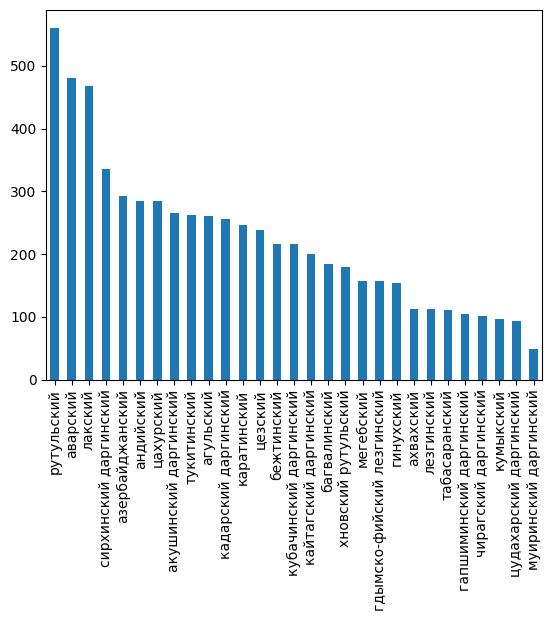

In [8]:
# plot the number of speakers per mother tongue
data['mother tongue'].value_counts().plot(kind='bar')
plt.show()

In [9]:
data.set_index('mother tongue', inplace=True)

In [10]:
matrix = data.loc[:, 'аварский': 'чирагский даргинский']
# only keep columns that are in len(data.index.unique())
matrix = matrix.loc[:, matrix.columns.isin(data.index.unique())]
matrix = matrix.astype(int)
matrix.columns

Index(['аварский', 'агульский', 'азербайджанский', 'акушинский даргинский',
       'андийский', 'ахвахский', 'багвалинский', 'бежтинский',
       'гапшиминский даргинский', 'гдымско-фийский лезгинский', 'гинухский',
       'кадарский даргинский', 'кайтагский даргинский', 'каратинский',
       'кубачинский даргинский', 'кумыкский', 'лакский', 'лезгинский',
       'мегебский', 'муиринский даргинский', 'рутульский',
       'сирхинский даргинский', 'табасаранский', 'тукитинский',
       'хновский рутульский', 'цахурский', 'цезский', 'цудахарский даргинский',
       'чирагский даргинский'],
      dtype='object')

In [11]:
# group by 'mother tongue' and sum
matrix = matrix.groupby(matrix.index).sum()
# turn to percentage
matrix = matrix.div(matrix.sum(axis=1), axis=0)
# add missing languages from columns to index
matrix = matrix.reindex(matrix.columns, axis=0, fill_value=0)
# if column == index, set to 0
matrix = matrix.where(matrix != matrix.T, 0)
# turn Nan to 0
matrix = matrix.fillna(0)

In [12]:
# if less that 5% of speakers speak 
# the language then set the relation to 0
matrix = matrix.where(matrix > 0.01, 0)

In [13]:
# # apply transliteration to index and columns
matrix.index = matrix.index.map(transliterate)
matrix.columns = matrix.columns.map(transliterate)

In [14]:
# convert matrix into a long dataframe with directed edges as rows
df = matrix.stack().reset_index()
df.columns = ['target', 'source', 'weight']
df.head()

# save to csv
df.to_csv('../data/edges.csv', index=False)

In [15]:
data.reset_index(inplace=True)

In [16]:
data.columns

Index(['mother tongue', 'residence', 'expedition', 'name', 'number of na',
       'russian na', 'sex', 'type', 'year_of_birth', 'year of death',
       'аварский', 'агульский', 'азербайджанский',
       'азербайджанский или кумыкский', 'акушинский даргинский', 'андийский',
       'арчинский', 'ахвахский', 'багвалинский', 'бежтинский', 'ботлихский',
       'гапшиминский даргинский', 'гдымско-фийский лезгинский', 'гинухский',
       'грузинский', 'даргинский', 'кадарский даргинский',
       'кайтагский даргинский', 'каратинский', 'кубачинский даргинский',
       'кумыкский', 'лакский', 'лезгинский', 'мегебский',
       'муиринский даргинский', 'русский', 'рутульский',
       'сирхинский даргинский', 'табасаранский', 'тукитинский',
       'хновский рутульский', 'цахурский', 'цезский', 'цудахарский даргинский',
       'чеченский', 'чирагский даргинский', 'village population',
       'language population', 'number of lang', 'mother tongue match',
       'number of lang strat', 'elevation_x'

In [17]:
# save coordinates and number of speakers to csv
df_info = data[['residence', 'mother tongue', 'lat', 'lon', 'village population']]
df_info.drop_duplicates(inplace=True)

# group by 'mother tongue' and compute average lat and lon and sum of population
df_info = df_info.groupby('mother tongue').agg({'lat': 'mean', 'lon': 'mean', 'village population': 'sum'})
df_info.reset_index(inplace=True)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_95502/1681993826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info.drop_duplicates(inplace=True)


In [18]:
# transliterate mother tongue
df_info['mother tongue'] = df_info['mother tongue'].map(transliterate)

In [19]:
df_info
# fill missing lat and lon with mean
df_info['lat'] = df_info['lat'].fillna(df_info['lat'].mean())
df_info['lon'] = df_info['lon'].fillna(df_info['lon'].mean())

In [20]:
# convert matrix into a networkx graph
G = nx.from_numpy_array(matrix.values)
# add direction to edges
G = nx.Graph(G)
# make it directed
G = G.to_directed()
# set node names
G = nx.relabel_nodes(G, dict(zip(range(len(matrix.columns)), matrix.columns)))

# use lat lon from df_info to set node positions
pos = dict(zip(df_info['mother tongue'], df_info[['lat', 'lon']].values))

# set node size to population
node_size = df_info['village population'].values

# add weight to edges and round them to 2 decimals
edge_width = [round(d['weight'], 2) * 10 for (u, v, d) in G.edges(data=True)]

# # reverse direction of edges
G = G.reverse()

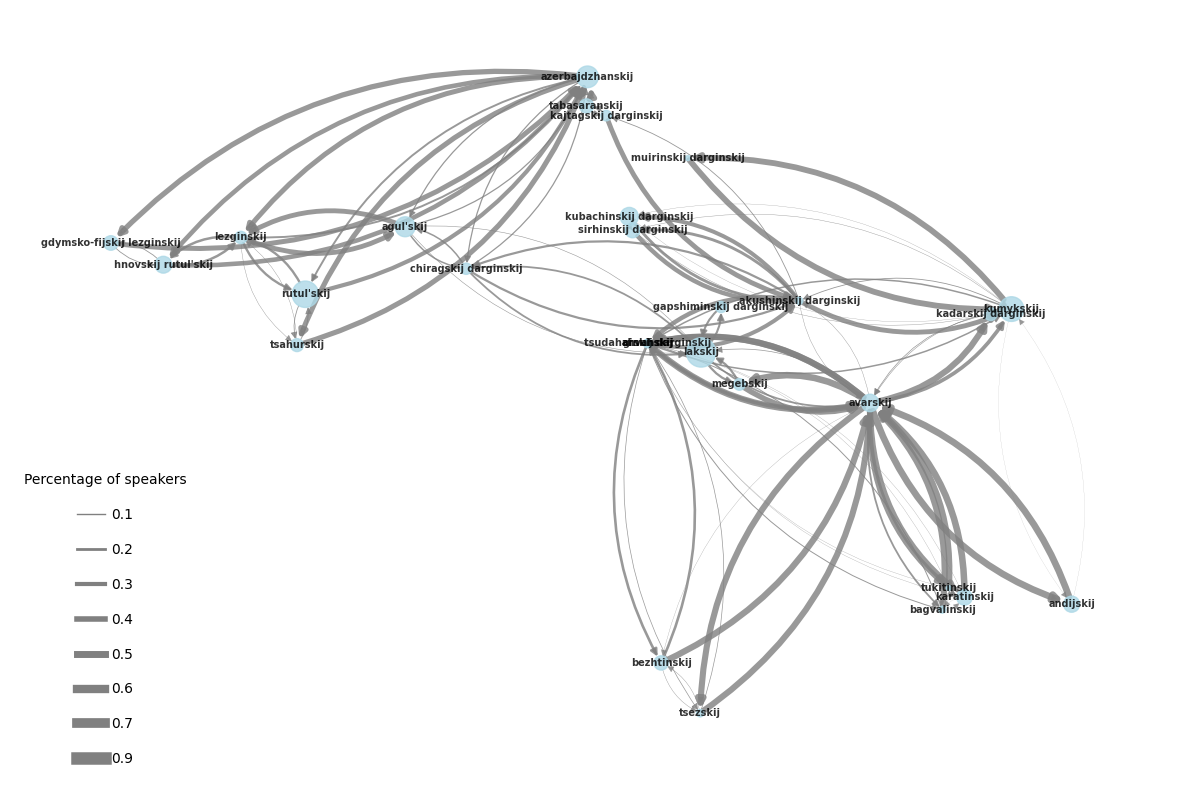

In [21]:
# plot graph
plt.figure(figsize=(15, 10))
nx.draw_networkx(G, pos=pos, node_size=node_size/10, 
                 node_color='lightblue', 
                 edge_color='grey', 
                 width=edge_width, 
                 font_size=7, 
                 font_weight='bold',
                 with_labels=True, 
                 alpha=0.8,
                 connectionstyle=f'arc3, rad = 0.25')
plt.axis('off')
# add legend for edge width

# create legend for edge width
edge_width = np.array(edge_width)
edge_width = edge_width[edge_width > 0]
edge_width = edge_width[edge_width < 1]
edge_width = np.unique(edge_width)
edge_width = edge_width * 10
edge_width = edge_width.astype(int)

for i in edge_width:
    plt.plot([], [], c='grey', linewidth=i, label=str(i/10))

plt.legend(title='Percentage of speakers',
              labelspacing=1.5,
                fontsize=10,
                frameon=False,
                handletextpad=0.5,
                borderpad=0.5,)
plt.show()